In [73]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
import keras.optimizers
#  Following are utility functions used later.

Blackjack Utility Functions

In [74]:
# Check if the hand is a blackjack
def is_blackjack(hand):
    if len(hand) > 2:
        return False
    else:
        if hand[0] == 1 and hand[1] == 10:
            return True
        elif hand[1] == 1 and hand[0] == 10:
            return True
        else:
            return False


# Check whether we busted    
def is_bust(hand):
    if sum(hand) > 21:
        return True
    else:
        return False


# Calculate score of a hand (takes into account aces)
def score_hand(hand):
    if 1 in hand:
        if sum(hand) + 10 <= 21:
            return sum(hand) + 10
        else:
            return sum(hand)
    else:
        return sum(hand)


# Check whether we have an ace whose value can still be either 1 or 11    
def has_usable_ace(hand):
    if 1 in hand:
        if sum(hand) + 10 <= 21:
            return 1
        else:
            return 0
    else:
        return 0

Card Utility Functions

In [75]:
# shuffle the cards.
def shuffle_cards(amount_decks):
    deck = []
    for d in range(1, amount_decks + 1):
        for i in range(1, 11):
            if i < 10:
                for amount in range(1, 5):
                    deck.append(i)
            if i == 10:
                for amount in range(1, 17):
                    deck.append(i)
    random.shuffle(deck)  
    return deck
# draw a card from the deck.
def draw_from_deck(deck, update, card_count_score):
    if len(deck) > 0:
        card = deck.pop(0)
        if update:
            if card >= 2 and card <= 6:
                card_count_score[0] = card_count_score[0] - 1
            if card == 1 or card == 10:
                card_count_score[0] = card_count_score[0] + 1
    else:
        print("no more cards")
        return 0
    return card             

Player Utility Functions

In [76]:
#  Player that does table lookup.
def action(player_hand, dealer_open_card, model, shuffle, shuffles, train, card_count_score):
    mid_shuffle = shuffles * epsilon_zero_point
    epsilon = 0 if not train else  start_epsilon * (max(0, ((mid_shuffle - shuffle) / mid_shuffle)))
    #  Calculate all state variables
    useable_ace = has_usable_ace(player_hand)
    score = score_hand(player_hand)
    s = [score, dealer_open_card, useable_ace, card_count_score]
    #  Act epsilon-greedy
    if random.random() <= epsilon:
        a = int((random.random()*100)) % 2
    else:
        #  Calculate expected payoff of hitting
        Q_0 = Q(0, s, model)
        #  Calculate expected payoff of sticking
        Q_1 = Q(1, s, model)
        if Q_0 >= Q_1:
            a = 0
        if Q_1 > Q_0:
            a = 1
    s.append(a)
    return s

def Q(action,state,model):
    Q_hat = nn_evaluate(action, state, model)
    return Q_hat
    

Neural Network Utility Functions

In [77]:
alpha = 0.05
epochs = 20
counter = 0
start_epsilon = 0.1

def create_neural_network(layers, activations):
  x = [[21, 9, 0, 1, 0], [15, 10, 0, 1, 1], [16, 4, 1, 0, -1], [18, 7, 0, 0, 0]]
  x = np.array(x)
  x = x.reshape(4, 5)
  y = [1, -0.7, 0.6, -1]
  y = np.array(y)
  model = Sequential()
  model.add(Dense(layers[0], input_dim=5, activation = activations[0]))
  model.add(Dense(layers[1], activation = activations[1]))
  model.add(Dense(1, activation = activations[2], kernel_regularizer=regularizers.l1(0.01)))
  opt = keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(loss='mse', optimizer=opt)
  model.fit(epochs=epochs,x=x , y=y , verbose=0)
  return model

#  Trains the neural network.
def nn_train(action, state, reward, next_action, next_state, terminal, model):
    global counter
    x = state.copy()
    x.append(action)
    x = np.array(x)
    x = x.reshape(1, 5)
    if terminal:
        y = reward
    else:
        y = reward + nn_evaluate(next_action, next_state, model)
    y = np.array(y)
    y = y.reshape(1, 1)
    epochs = 10
    model.fit(epochs=epochs, x=x, y=y, verbose=0)
    return model

# Evaluates the neural network.
def nn_evaluate(action, state, model):
    x = state.copy()
    x.append(action)
    x = np.array(x)
    x = x.reshape(1, 5)
    Q_hat = model.predict(x, verbose=0)
    return Q_hat


Initialisation of State

In [78]:
#Input variables for the game
amount_decks = 6
players = 1
shuffles = 1000
cards_required = 6
epsilon_zero_point = 0.6

In [79]:
# Play until the deck has been shuffled a certain amount of times
def play_for_shuffles(shuffles, train = True, model = create_neural_network(layers = [70, 70], activations = ['relu', 'relu', 'linear'])):
    # Track the rewards
    total_reward = 0
    total_reward_vec = []

    # Track what happend each game
    player_blackjack_dealer_blackjack = 0
    player_blackjack = 0
    player_busts = 0
    dealer_busts = 0
    dealer_win = 0
    player_win = 0
    draw = 0
    start_time = time.time()

    card_count_frequency = []
    for card_count_score in range(-50,51):
        card_count_frequency.append(0)

    for shuffle in range(1, shuffles + 1):
        if shuffle % 100 == 0:
            print("shuffle: " + str(shuffle))
        deck = shuffle_cards(amount_decks)

        # Play until the deck has to be shuffled
        card_count_score = []
        card_count_score.append(0)
        while (len(deck) > cards_required * (players + 1)):

            # Set the size of the reward (bet size)
            reward = 1

            # Deal hands to both players
            player_hand = []
            dealer_hand = []
            for i in range(0, 2):
                player_hand.append(draw_from_deck(deck, True, card_count_score))
                if i == 0:
                    dealer_hand.append(draw_from_deck(deck, True, card_count_score))
                else:
                    dealer_hand.append(draw_from_deck(deck, False, card_count_score))
            dealer_open_card = dealer_hand[0]

            # If our score is less than or equal to 11, we always hit
            while (score_hand(player_hand) <= 11):
                player_hand.append(draw_from_deck(deck, True, card_count_score))

            # Keep the game going until we hit a terminal state
            first_move = True
            next_state_action = []
            while (True):
                # Check whether player has blackjack
                if is_blackjack(player_hand):
                    # Check whether the dealer also has blackjack
                    if is_blackjack(dealer_hand):
                        player_blackjack_dealer_blackjack = player_blackjack_dealer_blackjack + 1
                        reward = reward * 0
                        break
                    else:
                        player_blackjack = player_blackjack + 1
                        reward = reward * 1
                        break

                if first_move:
                    # Let the player take an action
                    state_action = action(player_hand, dealer_open_card, model, shuffle, shuffles, train, card_count_score[0])
                    card_count_frequency[card_count_score[0] + 50] = 1 + card_count_frequency[card_count_score[0] + 50]
                    player_action = state_action.pop(len(state_action) - 1)
                    state = state_action
                else:
                    # Use the action already decided
                    state_action = next_state_action
                    player_action = state_action.pop(len(state_action) - 1)
                    state = state_action

                # Hit
                if player_action == 0:
                    player_hand.append(draw_from_deck(deck, True, card_count_score))
                    # Check whether we busted
                    if is_bust(player_hand):
                        player_busts = player_busts + 1
                        reward = reward * - 1
                        if train:
                            model = nn_train(player_action, state, reward, 0, 0, True, model)
                        break
                    # Decide next action (we do it here already, so that we can use it to train)
                    first_move = False
                    next_state_action = action(player_hand, dealer_open_card, model, shuffle, shuffles, train, card_count_score[0])
                    card_count_frequency[card_count_score[0] + 50] = 1 + card_count_frequency[card_count_score[0] + 50]
                    next_player_action = next_state_action.pop(len(next_state_action) - 1)
                    next_state = next_state_action
                    if train:
                        model = nn_train(player_action, state, 0, next_player_action, next_state, False, model)
                    next_state_action.append(next_player_action)

                # Stick
                if player_action == 1:
                    # Play out the dealer
                    while (score_hand(dealer_hand) < 17):
                        dealer_hand.append(draw_from_deck(deck, False, card_count_score))
                    # Dealer busts
                    if score_hand(dealer_hand) > 21:
                        dealer_busts = dealer_busts + 1
                        reward = reward * 1
                        if train:
                            model = nn_train(player_action, state, reward, 0, 0, True, model)
                        break
                    # Dealer wins
                    elif score_hand(dealer_hand) > score_hand(player_hand):
                        dealer_win = dealer_win + 1
                        reward = reward * -1
                        if train:
                            model = nn_train(player_action, state, reward, 0, 0, True, model)
                        break
                    # Player wins
                    elif score_hand(dealer_hand) < score_hand(player_hand):
                        player_win = player_win + 1
                        reward = reward * 1
                        if train:
                            model = nn_train(player_action, state, reward, 0, 0, True, model)
                        break
                    # Draw
                    else:
                        draw = draw + 1
                        reward = reward * 0
                        if train:
                            model = nn_train(player_action, state, reward, 0, 0, True, model)
                        break
            # Update total reward
            total_reward = total_reward + reward
            total_reward_vec.append(total_reward)
            if shuffle == int(shuffles * epsilon_zero_point):
                index = len(total_reward_vec)
    model.save_weights('weights')
    print("--- %s seconds ---" % (time.time() - start_time))
    return total_reward_vec, model, index  


In [80]:
total_reward_vec, model, index = play_for_shuffles(shuffles, train = True)

shuffle: 100
shuffle: 200
shuffle: 300
shuffle: 400
shuffle: 500
shuffle: 600
shuffle: 700
shuffle: 800
shuffle: 900
shuffle: 1000
--- 622.7235450744629 seconds ---


Plot Results

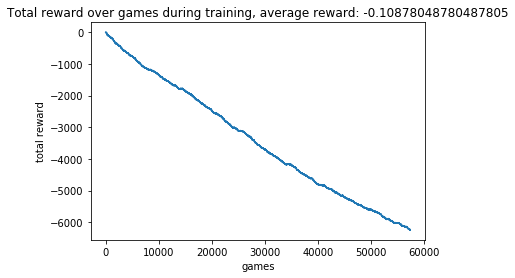

Stored 'total_reward_vec_NN_cardcount_training' (list)


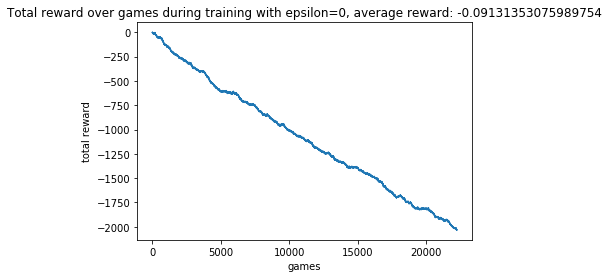

In [81]:
# Plot total reward 
plt.figure(1)
plt.plot(total_reward_vec)
plt.title('Total reward over games during training, average reward: ' + str(total_reward_vec[-1] / len(total_reward_vec)))
plt.xlabel('games')
plt.ylabel('total reward')
plt.show()
total_reward_vec_NN_cardcount_training=total_reward_vec.copy()
%store total_reward_vec_NN_cardcount_training
# Plot total reward 
plt.figure(2)
correction = total_reward_vec[index]
for i in range(0, len(total_reward_vec)):
    total_reward_vec[i] = total_reward_vec[i] - correction 
total_reward_vec = total_reward_vec[index + 1 : len(total_reward_vec)]   
plt.plot(total_reward_vec)
plt.title('Total reward over games during training with epsilon=0, average reward: ' + str(total_reward_vec[-1] / len(total_reward_vec)))
plt.xlabel('games')
plt.ylabel('total reward')
plt.show()

100 Shuffles for Validation

In [82]:
total_reward_vec, model, index = play_for_shuffles(100, train = False, model = model)

shuffle: 100
--- 7.341859579086304 seconds ---


Validation Reward Plotting

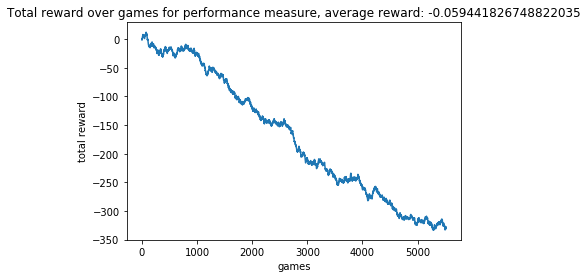

Stored 'total_reward_vec_NN_cardcount' (list)


In [83]:
# Plot total reward 
plt.figure(3)
plt.plot(total_reward_vec)
plt.title('Total reward over games for performance measure, average reward: ' + str(total_reward_vec[-1] / len(total_reward_vec)))
plt.xlabel('games')
plt.ylabel('total reward')
savelocation="rewards_NN_cardcount.png"
plt.savefig(savelocation)
plt.show()
r_notrain=total_reward_vec[-1] / len(total_reward_vec)
total_reward_vec_NN_cardcount=total_reward_vec.copy()
%store total_reward_vec_NN_cardcount

100 Shuffles for Further Training to Validate Convergence


In [84]:
total_reward_vec, model, _ = play_for_shuffles(100, train = True, model = model)
eta = 0.02

shuffle: 100
--- 69.47135996818542 seconds ---


100 Validation Shuffles to check Convergence

In [85]:
total_reward_vec, model, _ = play_for_shuffles(100, train = False, model = model)
r_train=total_reward_vec[-1] / len(total_reward_vec)

shuffle: 100
--- 6.998943328857422 seconds ---


Final Validation Convergence Plot

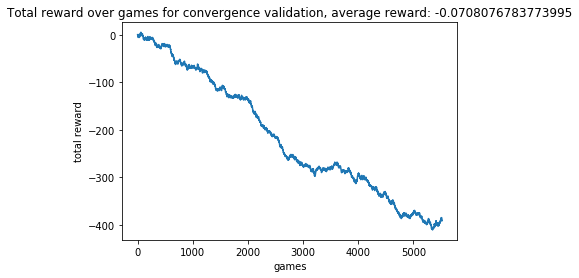

|r_notrain-r_train|=|-0.059441826748822035+-0.0708076783773995|=0.011365851628577464, which is less than eta, hence convergence


In [86]:
# Plot total reward 
plt.figure(4)
plt.plot(total_reward_vec)
plt.title('Total reward over games for convergence validation, average reward: ' + str(total_reward_vec[-1] / len(total_reward_vec)))
plt.xlabel('games')
plt.ylabel('total reward')
plt.show()

if abs(r_notrain-r_train)<eta:
    print('|r_notrain-r_train|=|' + str(r_notrain) + "+" + str(r_train) + "|=" + str(abs(r_notrain-r_train)) + ", which is less than eta, hence convergence")
else:
    print('|r_notrain-r_train|=|' + str(r_notrain) + "+" + str(r_train) + "|=" + str(abs(r_notrain-r_train)) + ", which is more than eta, hence no convergence")